Contributors: Thomas Asikis, Lucas Bottcher
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import torch
from neural_control.controllers import SingleFullyConnectedRegressionController
from neural_control.dynamics import SingleSourcingModel
from sourcing_models.utilities import sample_trajectories_single_sourcing
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from plotly import graph_objects as go

## Sourcing Problem Parameters

In [33]:
sourcing_parameters = dict(l=2,
                           h=5,
                           b=495,
                           T=50)

## NNC Initialization
Here we initialize an NNC model and set  its hyperparameters for training.

In [39]:
### One can experiment with different layer architectures and activations per layer
nnc_hyperparameters = dict(
    n_hidden_units = [8,4,2]
)

### We use celu non-linearities for the input layer, hidden layers, and output layer
nnc_hyperparameters['n_activations'] = [torch.nn.functional.celu]*(2 + len(nnc_hyperparameters['n_hidden_units']))


fcc = SingleFullyConnectedRegressionController(l=sourcing_parameters['l'], 
                                               n_hidden_units= nnc_hyperparameters ['n_hidden_units'],
                                               activations=nnc_hyperparameters['n_activations']
                                               ) # controller neural network object


## Dynamics Initialization
To further optimize NNC (''fine tuning''), we now apply gradient propagation to the inventory evolution equation:

$I_t = I_{t-1} + q^{\rm e}_{t-l_{\rm e}} + q^{\rm r}_{t-l_{\rm r}} - D_t$

where $I_0, q^{\rm e}_{t},q^{\rm r}_{t}$ are NNC outputs.

In [40]:
dsd = SingleSourcingModel(fcc, I_0=10, **sourcing_parameters) # Dual Sourcing Dynamics object

We preserve the best performing model in training, assuming that the neural network generalizes well during training and that our training sample is large enough.

In [41]:
best_loss = [np.infty]
best_model = [None]
all_training_costs = []

We observe that we have a neural network that outputs $q^{\rm r}_{t-l_{\rm r}}, q^{\rm e}_{t-l_{\rm e}}$ given the input described above.
The initial inventory $I_0$ is independent of inputs and can be learned separately (in a way that is similar to learning a bias term of a neural network).
We use separate optimizers to learn order quantities and initial inventory.
This may create learning variance, as one optimizer may overfit on a value that is directly changed by another optimizer. 
To reduce the learning variance, we let the order optimizer operate on 7 out of 10 learning epochs and the inventory optimizer on the remaining epochs.

In [44]:
optimizer = torch.optim.RMSprop(#[dsd.I_0],
                                list(fcc.parameters()), 
                                lr=1e-3
                               )
optimizer2 = torch.optim.RMSprop([dsd.I_0],
                                #list(fcc.parameters()), 
                                lr=1e-3
                               )

We now fine tune the model after imitation, in order to generalize and hopefully outperform the method used to train the model.
To do so, we repetively train and fine tune the parameters of 128 trajectories generated by setting a specific random seed. We do not resample new trajectories, as we want the network to overfit on the process. Sampling new samples could increase the input variance, and could potentially slow/prohibit convergence.

In [46]:
fine_tuning_iterations = 4000
minibatch_size = 256
random_seed = 4
for it in range(fine_tuning_iterations):
    optimizer.zero_grad()
    optimizer2.zero_grad()
    def closure():
        dsd.reset(minibatch_size, seed=random_seed+1)
        total_costs = 0
        for i in range(dsd.T):
            current_costs, demands, current_inventories, q, qa = dsd.simulate()
            total_costs = current_costs.mean() + total_costs
        all_training_costs.append(total_costs/dsd.T)
        total_costs.backward()
        if it % 20 == 0:
            print(total_costs/dsd.T)
        if total_costs < best_loss[0]:
            best_loss[0] = total_costs.detach().cpu().item()
            best_model[0] = deepcopy(fcc.state_dict())
        return total_costs
    if it % 10 > 6:
        optimizer2.step(closure)
    else:
        optimizer.step(closure)

tensor(32.4945, grad_fn=<DivBackward0>)
tensor(30.1160, grad_fn=<DivBackward0>)
tensor(30.7566, grad_fn=<DivBackward0>)
tensor(29.0516, grad_fn=<DivBackward0>)
tensor(29.3781, grad_fn=<DivBackward0>)
tensor(29.1527, grad_fn=<DivBackward0>)
tensor(29.1383, grad_fn=<DivBackward0>)
tensor(29.3543, grad_fn=<DivBackward0>)
tensor(29.2539, grad_fn=<DivBackward0>)
tensor(29.3543, grad_fn=<DivBackward0>)
tensor(29.7016, grad_fn=<DivBackward0>)
tensor(29.0516, grad_fn=<DivBackward0>)
tensor(29.0516, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


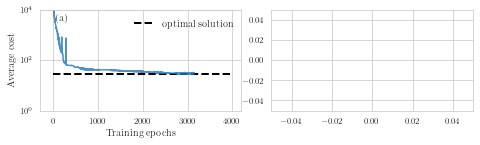

In [47]:
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 495    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, 0.5*fig_height]
rcParams.update({'figure.figsize': fig_size})

costs = torch.stack(all_training_costs).detach().numpy()
fig, ax = plt.subplots(ncols=2)
ax[0].text(0.02*2000,0.35*1e4,r"(a)")
ax[0].plot(costs,alpha=0.8)
ax[0].hlines(29,0,4000,linewidths=2,colors="k",linestyles="--")
ax[0].plot(-100,-100,linewidth=2,color="k",linestyle="--",label=r"optimal solution")
#ax[0].set_xlim(0,2000)
ax[0].set_ylim(1e0,1e4)
ax[0].set_yscale('log')
ax[0].set_yticks([1e0,1e2,1e4])
ax[0].yaxis.set_minor_formatter(NullFormatter())
ax[0].set_xlabel(r'Training epochs')
ax[0].set_ylabel(r'Average cost')
ax[0].legend(loc = 1, frameon=False)

#ax[1].text(0.02*(36-28)+28,0.88*0.6,r"(b)")

plt.tight_layout()
plt.margins(0,0)
#plt.savefig("training_base_stock.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

The above learning curve can be used to monitor learning.

After successful fine tuning we load the best performing model during training.

In [48]:
#best_model_load = torch.load('nnc_best_model_single_sourcing_l=2.pt', map_location='cpu')
#print(best_model_load)
#fcc.load_state_dict(best_model_load)
fcc.load_state_dict(best_model[0])

<All keys matched successfully>

We often train for $T=50$, but to study the ability of the model to generalize we report the average costs per timestep for $2048$ new samples and $T' = 1000$

In [49]:
fine_tuning_iterations = 1

for it in range(fine_tuning_iterations):

    dsd.reset(256)
    total_costs = 0
    for i in range(dsd.T+1000):
        current_costs, demands, current_inventories, q, qa = dsd.simulate()
        total_costs = current_costs.mean() + total_costs
    if it % 10 == 0:
        print('Reported mean cost per timestep is: ' + str(total_costs.item()/(dsd.T+1000)))

Reported mean cost per timestep is: 28.92739955357143


In [108]:
#torch.save(best_model[0], 'nnc_best_model_single_sourcing_l=2.pt')

## Comparison 
First, we generate a number of new single-sourcing samples.
These will be used to compare performance on unseen samples for NNC.

In [53]:
sourcing_parameters = dict(l=2,
                           h=5,
                           b=495,
                           T=1000)

state_trajectories, q_trajectories =\
    sample_trajectories_single_sourcing(n_trajectories=1000, r=10, seed=25, **sourcing_parameters)

In [54]:
dsd.reset(1)
def evaluate_nnc_on_sample(state_trajectories, 
                           sample_id):
    
    fixed_demands = state_trajectories[sample_id, 1:, 1].unsqueeze(-1)

    nn_inv = dsd.learned_I_0.detach().clone()
    dsd.reset(1)
    nn_q = [torch.zeros([1,1])]*dsd.l
    nn_ci = []
    all_nn_inv = [nn_inv.item()]
    D = torch.tensor(0.0).unsqueeze(0).unsqueeze(0)
    for i in range(sourcing_parameters["T"]):
        q = fcc(D, nn_inv, nn_q)
        D = fixed_demands[i].unsqueeze(0)
        nn_q.append(q)
        qa = nn_q[-dsd.l-1]
        c_i, nn_inv = dsd.replay_step(nn_inv, D, qa, q)
        nn_ci.append(c_i)
        all_nn_inv.append(nn_inv.item())
    return all_nn_inv, nn_q, nn_ci, torch.stack(nn_ci).mean()

In [55]:
def evaluate_ss_on_sample(state_trajectories, 
                          q_trajectories, 
                          sample_id):
    
    dsd.reset(1)
    fixed_demands = state_trajectories[sample_id, 1:, 1].unsqueeze(-1)

    ds_inv = state_trajectories[sample_id, 0, 0].unsqueeze(0).unsqueeze(0)
    dsd.reset(1)
    all_q = [0]*dsd.l
    all_ci = []
    all_inv = [ds_inv.detach().item()]
    for i in range(sourcing_parameters["T"]):
        D = fixed_demands[i].unsqueeze(0)
        if dsd.l == 0:
            q = q_trajectories[sample_id, i+1]
        else:
            q = q_trajectories[sample_id, dsd.l+i]
        
        all_q.append(q)
        qa = all_q[-dsd.l-1]
        c_i, ds_inv = dsd.replay_step(ds_inv, D, qa, q)
        all_inv.append(ds_inv.detach().item())
        all_ci.append(c_i)
    # test if calculated inventories and costs are the same as the ones reported
    # from the dual sourcing code
    assert torch.all(torch.tensor(all_inv) == state_trajectories[sample_id, :, 0])
    assert torch.all(torch.tensor(all_ci) == state_trajectories[sample_id, 1:, -1])
    return all_inv, all_q, all_ci, torch.stack(all_ci).mean()

In [56]:
cost_ratios = []
cost_nn = []
cost_ss = []

samples = 50
for i in range(samples):
    print("%d/%d samples completed"%(i,samples))
    nn_inv, nn_q, nn_ci, nn_mean_cost = evaluate_nnc_on_sample(state_trajectories, 
                                                               i)
    
    ss_inv, ss_q, ss_ci, ss_mean_cost = evaluate_ss_on_sample(state_trajectories, 
                                                              q_trajectories, 
                                                              i)
    cost_nn.append(nn_mean_cost.detach().item())
    cost_ss.append(ss_mean_cost.detach().item())
    cost_ratios.append(nn_mean_cost.detach().item()/ss_mean_cost.detach().item())

0/50 samples completed
1/50 samples completed
2/50 samples completed
3/50 samples completed
4/50 samples completed
5/50 samples completed
6/50 samples completed
7/50 samples completed
8/50 samples completed
9/50 samples completed
10/50 samples completed
11/50 samples completed
12/50 samples completed
13/50 samples completed
14/50 samples completed
15/50 samples completed
16/50 samples completed
17/50 samples completed
18/50 samples completed
19/50 samples completed
20/50 samples completed
21/50 samples completed
22/50 samples completed
23/50 samples completed
24/50 samples completed
25/50 samples completed
26/50 samples completed
27/50 samples completed
28/50 samples completed
29/50 samples completed
30/50 samples completed
31/50 samples completed


KeyboardInterrupt: 

In [57]:
(np.array(cost_ratios) < 1).sum()/len(cost_ratios)

1.0

In [58]:
np.mean(cost_ratios)

0.9996558809958944

In [59]:
np.mean(cost_nn)

29.144677254461474

In [60]:
np.mean(cost_ss)

29.15467736028856

Below we plot the distribution of the mean cost per step ratio between NNC and DI.

In [279]:
fig = go.Figure(go.Histogram(x=cost_ratios))
fig.add_vline(x=np.mean(cost_ratios))
fig.layout.xaxis.title = r'$\dfrac{\bar{c}_{\text{NNC}}}{\bar{c}_{\text{Single Index}}}$'
fig.layout.yaxis.title = 'Count'
fig

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


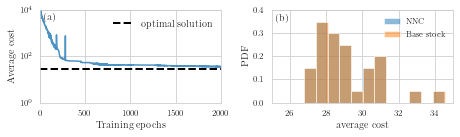

In [66]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 469    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, 0.5*fig_height]
rcParams.update({'figure.figsize': fig_size})


fig, ax = plt.subplots(ncols=2)
ax[0].text(0.02*2000,0.35*1e4,r"(a)")
ax[0].plot(costs,alpha=0.8)
ax[0].hlines(29,0,4000,linewidths=2,colors="k",linestyles="--")
ax[0].plot(-100,-100,linewidth=2,color="k",linestyle="--",label=r"optimal solution")
ax[0].set_xlim(0,2000)
ax[0].set_ylim(1e0,1e4)
ax[0].set_yscale('log')
ax[0].set_yticks([1e0,1e2,1e4])
ax[0].yaxis.set_minor_formatter(NullFormatter())
ax[0].set_xlabel(r'Training epochs')
ax[0].set_ylabel(r'Average cost')
ax[0].legend(loc = 1, frameon=False)

ax[1].text(0.02*(35-25)+25,0.88*0.4,r"(b)")
ax[1].hist(cost_nn,alpha=0.5,bins=12,density=True,label=r"NNC")
ax[1].hist(cost_ss,alpha=0.5,bins=12,density=True,label=r"Base stock")
ax[1].set_xlim(25,35)
ax[1].set_ylim(0,0.4)
ax[1].set_xlabel(r"average cost")
ax[1].set_ylabel(r"PDF")
ax[1].legend(loc=1,fontsize=8,frameon=False)

plt.tight_layout()
plt.margins(0,0)
#plt.savefig("training_base_stock.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()


## Single sample comparison
Now we compare the 2 models on a single random sample from the above to examine the difference between NNC and DI control trajectories.

In [61]:
fixed_demands = state_trajectories[20, 0:, 1].unsqueeze(-1)
nn_inv, nn_q, nn_ci, nn_mean_cost = evaluate_nnc_on_sample(state_trajectories, 20)
ss_inv, ss_q, ss_ci, ss_mean_cost = evaluate_ss_on_sample(state_trajectories, q_trajectories, 20)

In [141]:
a = go.Scatter(y=[x.item() for x in nn_q], name='NNC')
b = go.Scatter(y=ss_q, name='SS')
fig = go.Figure([a,b])
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Order'
fig

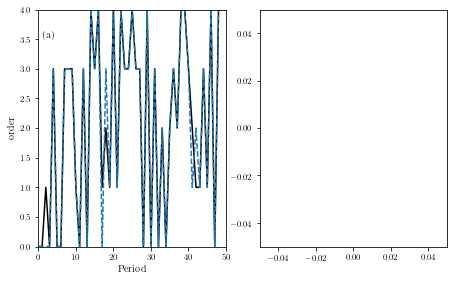

In [309]:
fig, ax = plt.subplots(ncols=2)
ax[0].text(0.02*50,0.88*4,r"(a)")
ax[0].plot([x.item() for x in nn_q],color="k")
ax[0].plot(ss_q,ls="--")
ax[0].set_xlim(0,50)
ax[0].set_ylim(0,4)
ax[0].set_xlabel(r"Period")
ax[0].set_ylabel(r"order")

plt.tight_layout()
plt.margins(0,0)
plt.savefig("q_comparison_single_sourcing.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

In [130]:
a = go.Scatter(y=[x.item() for x in nn_ci], name='NNC')
b = go.Scatter(y=[x.item() for x in ss_ci], name='SS')
fig = go.Figure([a,b])
fig.add_hline(nn_mean_cost.detach().item())
fig.add_hline(ss_mean_cost.detach().item(),line={'dash':'dash'})
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Cost'
fig

In [311]:
a = go.Scatter(y=nn_inv, name='NNC Inventory')
b = go.Scatter(y=ss_inv, name='SS Inventory')
c = go.Scatter(y=[x.detach().item() for x in fixed_demands], name='Demand',
               x=torch.arange(1, 1001).tolist() )
fig = go.Figure([a,b, c])
fig.layout.xaxis.title = 'Timestep'
fig.layout.yaxis.title = 'Quantity'
fig


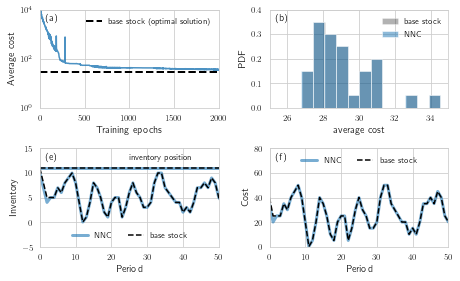

In [68]:
# set nice figure sizes
fig_width_pt = 469    # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, fig_height]
rcParams.update({'figure.figsize': fig_size})

fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].text(0.03*2000,0.35*1e4,r"(a)")
ax[0,0].plot(costs,alpha=0.8)
ax[0,0].hlines(29,0,4000,linewidths=2,colors="k",linestyles="--")
ax[0,0].plot(-100,-100,linewidth=2,color="k",linestyle="--",label=r"base stock (optimal solution)")
ax[0,0].set_xlim(0,2000)
ax[0,0].set_ylim(1e0,1e4)
ax[0,0].set_yscale('log')
ax[0,0].set_yticks([1e0,1e2,1e4])
ax[0,0].yaxis.set_minor_formatter(NullFormatter())
ax[0,0].set_xlabel(r'Training epochs')
ax[0,0].set_ylabel(r'Average cost')
ax[0,0].legend(loc = 1, fontsize=8, frameon=False)

ax[0,1].text(0.03*(35-25)+25,0.88*0.4,r"(b)")
ax[0,1].hist(cost_ss,alpha=0.3,bins=12,density=True,color="k",label=r"base stock")
ax[0,1].hist(cost_nn,alpha=0.5,bins=12,density=True,label=r"NNC")
ax[0,1].set_xlim(25,35)
ax[0,1].set_ylim(0,0.4)
ax[0,1].set_xlabel(r"average cost")
ax[0,1].set_ylabel(r"PDF")
ax[0,1].legend(loc=1,fontsize=8,frameon=False)

ax[1,0].text(0.03*50,0.88*(15+5)-5,r"(e)")
ax[1,0].text(0.5*50, 0.88*(15+5)-5,"inventory position",fontsize=8)
ax[1,0].plot(nn_inv,linewidth=3,color="tab:blue",alpha=0.6,label=r"NNC")
ax[1,0].plot(ss_inv,color="k",ls="--",label=r"base stock")
ax[1,0].plot([sum(nn_q[i:i+1+sourcing_parameters["l"]])+int(nn_inv[i]) for i in range(len(nn_inv)-2)],\
              linewidth=3,color="tab:blue",alpha=0.6)
ax[1,0].plot([sum(ss_q[i:i+1+sourcing_parameters["l"]])+int(ss_inv[i]) for i in range(len(ss_inv)-2)],ls="--",color="k")
ax[1,0].set_xlim(0,50)
ax[1,0].set_ylim(-5,15)
ax[1,0].set_xlabel(r"Period")
ax[1,0].set_ylabel(r"Inventory")
ax[1,0].legend(loc=8,fontsize=8,ncol=2,frameon=False)

ax[1,1].text(0.03*50,0.88*80,r"(f)")
ax[1,1].plot([x.item() for x in nn_ci],linewidth=3,alpha=0.6,label=r"NNC")
ax[1,1].plot([x.item() for x in ss_ci],color="k",label=r"base stock",ls="--")
ax[1,1].set_xlim(0,50)
ax[1,1].set_ylim(0,80)
ax[1,1].set_xlabel(r"Period")
ax[1,1].set_ylabel(r"Cost")
ax[1,1].legend(loc=9,fontsize=8,ncol=2,frameon=False)

plt.tight_layout()
plt.margins(0,0)
#plt.savefig("training_base_stock.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()

In [112]:
b = 0
for d1 in range(0,5):
    for d2 in range(0,5):
        for d3 in range(0,5):
            if d1+d2+d3 >= 11:
                b += (d1+d2+d3-11)/125

In [116]:
5*(5+1/125)+495*1/125

29.0

In [63]:
import seaborn as sns

In [64]:
mosaic = """
    AA
    BC
    """

No handles with labels found to put in legend.
/home/lucasb/anaconda3/envs/inventory/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 



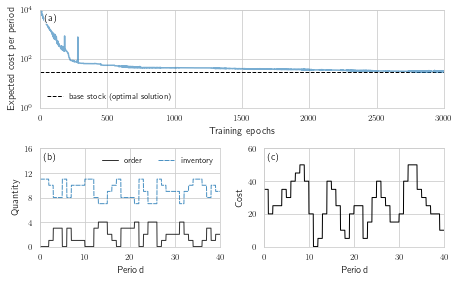

In [77]:
sns.set_style("whitegrid")

fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
text = ax_dict["A"].text(0.01*3000,0.35*1e4,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
ax_dict["A"].plot(costs,alpha=0.6)
ax_dict["A"].hlines(29,0,5000,linewidths=1,colors="k",linestyles="--")
ax_dict["A"].plot(-100,-100,linewidth=1,color="k",linestyle="--",label=r"base stock (optimal solution)")
ax_dict["A"].set_xlim(0,3000)
ax_dict["A"].set_ylim(1e0,1e4)
ax_dict["A"].set_yscale('log')
ax_dict["A"].set_yticks([1e0,1e2,1e4])
ax_dict["A"].yaxis.set_minor_formatter(NullFormatter())
ax_dict["A"].set_xlabel(r'Training epochs')
ax_dict["A"].set_ylabel(r'Expected cost per period')
ax_dict["A"].legend(loc = 3, fontsize=8, frameon=False)

orders = nn_q[:][:40]
orders = np.repeat(orders,20)
inventory_pos = [int(nn_inv[i])+int(nn_q[i+1])+int(nn_q[i+2]) for i in range(len(nn_inv)-2)][:40]
inventory_pos = np.repeat(inventory_pos,20)
t_arr = np.linspace(0,40,len(orders))

ax_dict["B"].text(0.02*40,0.88*16,r"(b)")
#ax[1,0].text(0.5*17, 4.3,r"inventory position ($z^*+1$)",fontsize=9)
#ax[1,0].plot(nn_inv,linewidth=1,color="tab:blue",alpha=0.8,label=r"inventory")
ax_dict["B"].plot(t_arr,orders,linewidth=1,color="k",alpha=0.8,label=r"order")
ax_dict["B"].plot(t_arr,inventory_pos,\
             linewidth=1,color="tab:blue",alpha=0.8,label=r"inventory",linestyle=(0, (5, 1)))
ax_dict["B"].set_xlim(0,40)
ax_dict["B"].set_ylim(0,16)
ax_dict["B"].set_yticks([0,4,8,12,16])
ax_dict["B"].set_xlabel(r"Period")
ax_dict["B"].set_ylabel(r"Quantity")
ax_dict["B"].legend(loc=1,fontsize=8,ncol=2,frameon=False)

cost = [x.item() for x in nn_ci][:40]
cost = np.repeat(cost,20)

ax_dict["C"].text(0.02*40,0.88*60,r"(c)")
ax_dict["C"].plot(t_arr,cost,linewidth=1,color="k")
ax_dict["C"].set_xlim(0,40)
ax_dict["C"].set_ylim(0,60)
ax_dict["C"].set_xlabel(r"Period")
ax_dict["C"].set_ylabel(r"Cost")
ax_dict["C"].legend(loc=9,fontsize=8,ncol=2,frameon=False)

plt.tight_layout()
plt.margins(0,0)
plt.savefig("training_base_stock_l=2.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)
plt.show()